In [8]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing
import cv2
import pandas as pd

In [9]:
from keras.layers import GlobalAveragePooling2D, Reshape, Convolution2D


In [10]:
import nibabel as nib

In [11]:
IMG_SIZE=128
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', 
    2 : 'EDEMA',
    3 : 'ENHANCING'}


VOLUME_SLICES = 128
VOLUME_START_AT = 22

In [12]:
TRAIN_DATASET_PATH = '/Users/sanjaydilli/Downloads/archive/BraTS2021_Training_Data'


In [13]:
import os
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

In [14]:
def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories);


train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2)
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15)

In [15]:
keras = tf.compat.v1.keras
Sequence = keras.utils.Sequence

class DataGenerator(Sequence):
    
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
       
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        Batch_ids = [self.list_IDs[k] for k in indexes]

       
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
       
       
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 128, 128))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))
        
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii.gz');
            flair = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_t1ce.nii.gz');
            ce = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_seg.nii.gz');
            seg = nib.load(data_path).get_fdata()

            for j in range(VOLUME_SLICES):
             X[j+(VOLUME_SLICES*c),:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

             X[j+(VOLUME_SLICES*c),:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))


             y[j +VOLUME_SLICES*c,:,:] = cv2.resize(seg[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
       
       
        y[y==4] = 3;
        y = tf.one_hot(y, 4);
        return X/np.max(X), y

training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

In [16]:
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss

 

def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)


def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
     
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())



def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [17]:
csv_logger = CSVLogger('training.log', separator=',', append=False)


callbacks = [keras.callbacks.EarlyStopping(monitor='loss', min_delta=0,
                               patience=5, verbose=1, mode='auto'),
             keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=5,mode='max'),
      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001, verbose=1),
      csv_logger
    ]

In [11]:
def conv_block(X,filters):
   
    f1,f2,f3 = filters
    X_skip = X
    
    X = Convolution2D(filters=f1,kernel_size=(1,1),dilation_rate=(1,1),padding='same',kernel_initializer='he_normal')(X)
    X = BatchNormalization()(X)
    X = LeakyReLU(alpha=0.2)(X)
    
    X = Convolution2D(filters=f2,kernel_size=(3,3),dilation_rate=(2,2),padding='same',kernel_initializer='he_normal')(X)
    X = BatchNormalization()(X)
    X = LeakyReLU(alpha=0.2)(X)
    
    X = Convolution2D(filters=f3,kernel_size=(1,1),dilation_rate=(1,1),padding='same',kernel_initializer='he_normal')(X)
    X = BatchNormalization()(X)

    X_skip = Convolution2D(filters=f3,kernel_size=(3,3),padding='same')(X_skip)
    X_skip = BatchNormalization()(X_skip)

    X = Add()([X,X_skip])
    X = ReLU()(X)
    return X
    
def base_feature_maps(input_layer):
    
    
   
    base = conv_block(input_layer,[32,32,64])
    
    base = conv_block(base,[64,64,128])
    
    return base

def pyramid_feature_maps(input_layer):
   
    
    base = base_feature_maps(input_layer)
    
    conv1 = GlobalAveragePooling2D()(base)
    conv1 = tf.keras.layers.Reshape((1,1,128))(conv1)
    conv1 = Convolution2D(filters=64,kernel_size=(1,1))(conv1)
    conv1 = UpSampling2D(size=128,interpolation='bilinear')(conv1)
    
    conv2 = AveragePooling2D(pool_size=(2,2))(base)
    conv2 = Convolution2D(filters=64,kernel_size=(1,1))(conv2)
    conv2 = UpSampling2D(size=2,interpolation='bilinear')(conv2)
  
    conv3 = AveragePooling2D(pool_size=(4,4))(base)
    conv3 = Convolution2D(filters=64,kernel_size=(1,1))(conv3)
    conv3 = UpSampling2D(size=4,interpolation='bilinear')(conv3)
   
    conv4 = AveragePooling2D(pool_size=(8,8))(base)
    conv4 = Convolution2D(filters=64,kernel_size=(1,1))(conv4)
    conv4 = UpSampling2D(size=8,interpolation='bilinear')(conv4)
    
    return tf.keras.layers.concatenate([base,conv1,conv2,conv3,conv4])

def last_conv_module(input_layer):
    X = pyramid_feature_maps(input_layer)
    X = Conv2D(4, (1,1), activation = 'softmax')(X)
    return X

In [14]:
input_layer = Input((128,128,2))

In [15]:
output_layer = last_conv_module(input_layer)

In [16]:
PSP_net = tf.keras.Model(inputs=input_layer,outputs=output_layer)

In [18]:
PSP_net.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4),
                                                                                                                dice_coef, precision, sensitivity, specificity, dice_coef_necrotic,
                                                                                                                dice_coef_edema ,dice_coef_enhancing] )
PSP_net.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 2  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_13 (Conv2D)             (None, 128, 128, 32  96          ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 128, 128, 32  128        ['conv2d_13[0][0]']              
 rmalization)                   )                                                             

                                                                                                  
 average_pooling2d_3 (AveragePo  (None, 64, 64, 128)  0          ['re_lu_3[0][0]']                
 oling2D)                                                                                         
                                                                                                  
 average_pooling2d_4 (AveragePo  (None, 32, 32, 128)  0          ['re_lu_3[0][0]']                
 oling2D)                                                                                         
                                                                                                  
 average_pooling2d_5 (AveragePo  (None, 16, 16, 128)  0          ['re_lu_3[0][0]']                
 oling2D)                                                                                         
                                                                                                  
 conv2d_21

In [ ]:
history =  PSP_net.fit(training_generator,
                     epochs=30,
                     steps_per_epoch= 300,
                     callbacks= callbacks,
                     validation_data = valid_generator
                     )

Epoch 1/30


2023-12-18 11:04:05.409842: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-12-18 11:04:05.413604: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


300/300 [==============================] - ETA: 0s - loss: 0.0341 - accuracy: 0.9909 - mean_io_u_1: 0.3752 - dice_coef: 0.4822 - precision: 0.9922 - sensitivity: 0.9877 - specificity: 0.9975 - dice_coef_necrotic: 0.2006 - dice_coef_edema: 0.5396 - dice_coef_enhancing: 0.5301 

2023-12-18 12:20:41.834728: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


300/300 [==============================] - 5329s 18s/step - loss: 0.0341 - accuracy: 0.9909 - mean_io_u_1: 0.3752 - dice_coef: 0.4822 - precision: 0.9922 - sensitivity: 0.9877 - specificity: 0.9975 - dice_coef_necrotic: 0.2006 - dice_coef_edema: 0.5396 - dice_coef_enhancing: 0.5301 - val_loss: 0.0930 - val_accuracy: 0.9820 - val_mean_io_u_1: 0.3750 - val_dice_coef: 0.2796 - val_precision: 0.9830 - val_sensitivity: 0.9813 - val_specificity: 0.9944 - val_dice_coef_necrotic: 0.0563 - val_dice_coef_edema: 0.1109 - val_dice_coef_enhancing: 0.0258 - lr: 0.0010
Epoch 2/30
300/300 [==============================] - 5280s 18s/step - loss: 0.0253 - accuracy: 0.9922 - mean_io_u_1: 0.3751 - dice_coef: 0.5115 - precision: 0.9935 - sensitivity: 0.9912 - specificity: 0.9978 - dice_coef_necrotic: 0.2642 - dice_coef_edema: 0.5552 - dice_coef_enhancing: 0.6062 - val_loss: 0.1463 - val_accuracy: 0.9670 - val_mean_io_u_1: 0.3750 - val_dice_coef: 0.3606 - val_precision: 0.9737 - val_sensitivity: 0.9647 - v

In [ ]:
PSP_net.save('PSPnet.h5')

In [18]:
model = keras.models.load_model('/Users/sanjaydilli/PSPnet/PSPnet.h5', 
                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_necrotic": dice_coef_necrotic,
                                                   "dice_coef_edema": dice_coef_edema,
                                                   "dice_coef_enhancing": dice_coef_enhancing
                                                  }, compile=False)


In [13]:
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing] )


In [15]:
print("Evaluate on test data")
results = model1.evaluate(test_generator, callbacks= callbacks)
print("test loss, test acc:", results)

Evaluate on test data


2023-12-19 14:29:34.638559: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-12-19 14:29:34.931131: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


150/150 [==============================] - 1449s 10s/step - loss: 0.1846 - accuracy: 0.9620 - mean_io_u_2: 0.3750 - dice_coef: 0.3895 - precision: 0.9656 - sensitivity: 0.9607 - specificity: 0.9887 - dice_coef_necrotic: 0.1987 - dice_coef_edema: 0.2665 - dice_coef_enhancing: 0.3093
test loss, test acc: [0.1845867931842804, 0.9619909524917603, 0.37500303983688354, 0.3895031809806824, 0.9656272530555725, 0.960655927658081, 0.9887273907661438, 0.19869281351566315, 0.26651495695114136, 0.30931517481803894]


In [3]:
history = pd.read_csv('/Users/sanjaydilli/PSPnet/training.log', sep=',', engine='python')
hist=history

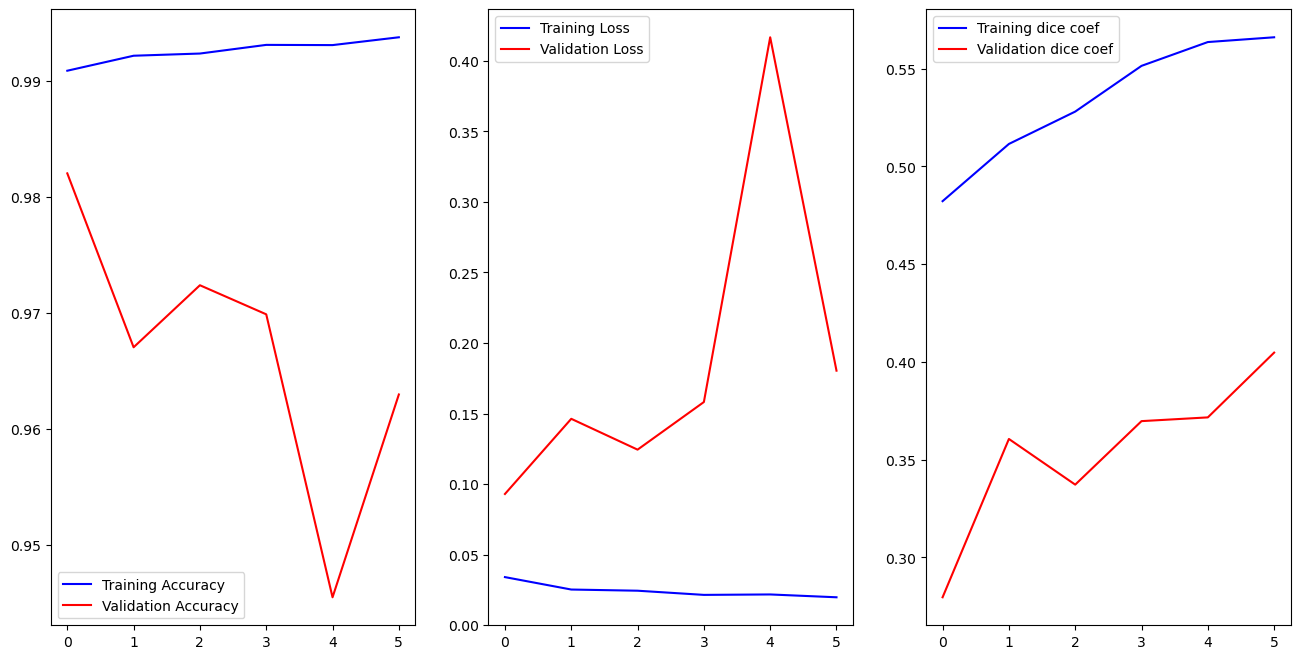

In [4]:
acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

f,ax=plt.subplots(1,3,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch,train_dice,'b',label='Training dice coef')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[2].legend()



plt.show()

In [5]:
def predictByPath(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
 
    
    vol_path = os.path.join(case_path, f'BraTS2021{case}_flair.nii.gz');
    flair=nib.load(vol_path).get_fdata()
    
    vol_path = os.path.join(case_path, f'BraTS2021{case}_t1ce.nii.gz');
    ce=nib.load(vol_path).get_fdata() 
    

    
    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
 
    return model.predict(X/np.max(X), verbose=1)


In [21]:
def showPredictsById(case, start_slice = 60):
    path = f"/Users/sanjaydilli/Downloads/archive/BraTS2021_Training_Data/BraTS2021{case}"
    gt = nib.load(os.path.join(path, f'BraTS2021{case}_seg.nii.gz')).get_fdata()
    origImage = nib.load(os.path.join(path,f'BraTS2021{case}_flair.nii.gz')).get_fdata()
    p = predictByPath(path,case)

    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50)) 

    for i in range(6):
        axarr[i].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')
    
    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    curr_gt=cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3) # ,alpha=0.3,cmap='Reds'
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('all classes')
    axarr[3].imshow(edema[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.show()
    

4/4 [==============================] - 3s 665ms/step


<Figure size 1800x5000 with 0 Axes>

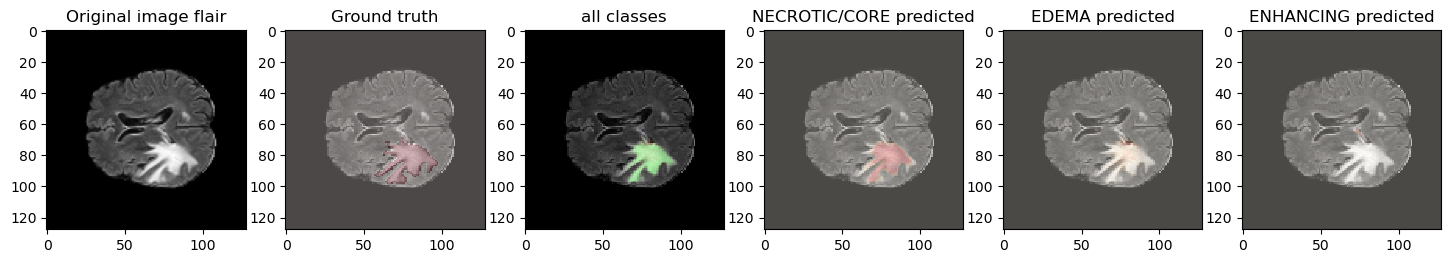

In [22]:
showPredictsById(case=test_ids[4][-6:])